# CM4107 Advanced Artificial Intelligence
## Coursework Part 1 - kNN
## Alistair Quinn 1701183

### Imports

In [130]:
%matplotlib inline
import numpy as np
import scipy.special 
import matplotlib.pyplot as plt
import pandas as pd
import random
import operator

### Load Train and Test Datasets 

In [131]:
datasets = {'wine':{},'breast_cancer':{}}
#Dataset 1: Wine
datasets['wine']['train'] = pd.read_csv('datasets/wine/wine_train.csv')
datasets['wine']['train_x'] = datasets['wine']['train'].iloc[:,1:12]
datasets['wine']['train_y'] = datasets['wine']['train'].iloc[:,0:1]
datasets['wine']['test'] = pd.read_csv('datasets/wine/wine_test.csv')
datasets['wine']['test_x'] = datasets['wine']['test'].iloc[:,1:12]
datasets['wine']['test_y'] = datasets['wine']['test'].iloc[:,0:1]
#Dataset 2: Breast Cancer 
datasets['breast_cancer']['train'] = pd.read_csv('datasets/breast_cancer/breast_cancer_train.csv')
datasets['breast_cancer']['train_x'] = datasets['breast_cancer']['train'].iloc[:,1:33]
datasets['breast_cancer']['train_y'] = datasets['breast_cancer']['train'].iloc[:,0:1]
datasets['breast_cancer']['test'] = pd.read_csv('datasets/breast_cancer/breast_cancer_test.csv')
datasets['breast_cancer']['test_x'] = datasets['breast_cancer']['test'].iloc[:,1:33]
datasets['breast_cancer']['test_y'] = datasets['breast_cancer']['test'].iloc[:,0:1]

### Simulatiry Functions 
#### From Lab 4

In [132]:
#Within our class we now need code for each of the components of k-NN.
#First, lets create a method that will measure the distance between two vectors.
def euclidean(instance1, instance2):
        '''
        Calculates euclidean distance between two instances of data
        instance1 will be a List of Float values
        instance2 will be a List of Float values
        length will be an Integer denoting the length of the Lists
        '''
        distance = 0
        for val1, val2 in zip(instance1, instance2):            
            distance += pow((val1 - val2), 2)
        
        distance = pow(distance, 1/2)
             
              
        return 1 / (1+ distance)
    

def manhattan(instance1, instance2):
        '''
        Calculates manhattan distance between two instances of data
        instance1 will be a List of Float values
        instance2 will be a List of Float values
        length will be an Integer denoting the length of the Lists
        '''
        distance = 0
        for val1, val2 in zip(instance1, instance2):
            distance += abs(val1 - val2)      
              
        return 1 / (1+ distance)
    
def dot_product(instance1, instance2):
        '''
        Calculates dot product between two instances 
        instance1 will be a List of Float values
        instance2 will be a List of Float values
        length will be an Integer denoting the length of the Lists
        '''
        return np.dot(instance1, instance2)

#https://masongallo.github.io/machine/learning,/python/2016/07/29/cosine-similarity.html
def cosine(instance1, instance2):
    dot_prod = dot_product(instance1,instance2)
    norm_1= np.linalg.norm(instance1)
    norm_2= np.linalg.norm(instance2)
    return dot_prod / (norm_1 * norm_2)

### kNN Class
#### From Lab 4

In [133]:
class kNN:
    """
    Parameters
    X_train, Y_train : list
    these consists of the training set feature values and associated class labels
    k : int
    specify the number of neighbours
    sim : literal
    specify the name of the similarity metric (e.g. manhattan, eucliedean)
    weighted : Boolean
    specify the voting strategy as weighted or not weighted by similarity values
  
    Attributes
    -----------  
    Results : list
      Target and predicted class labels for the test data.    
    """


    def __init__(self, X_train, Y_train, k=3, sim=manhattan, weighted=False):
        self.X_train = X_train
        self.Y_train = Y_train
        
        if k <= len(self.X_train):
            self.k = k # set the k value for neighbourhood size
        else:
            self.k = len(self.X_train) # to ensure the get_neighbours dont crash
    
        self.similarity = sim # specify a sim metric that has been pre-defined e.g. manhattan or euclidean
        
        self.weighted = weighted # boolean to choose between weighted / unweighted majority voting
        
        #store results from testing 
        self.results= []
        
    #With k-NN, we are interested in finding the k number of points with the greatest similarity 
    # to the the query or test instance.
    def get_neighbours(self, test_instance):
        '''
        Locate most similar neighbours 
        X_train will be a containing features (Float) values (i.e. your training data)
        Y_train will be the corresponding class labels for each instance in X_train
        test_instance will be a List of Float values (i.e. a query instance)
        '''
        similarities = [] # collection to store the similarities to be computed

        for train_instance, y in zip(self.X_train, self.Y_train): #for each member of the training set
            sim = self.similarity(test_instance, train_instance) #calculate the similarity to the test instance
            
            similarities.append((y, sim)) #add the actual label of the example and the computed similarity to a collection 
        #print(distances)
        similarities.sort(key = operator.itemgetter(1), reverse = True) #sort the collection by decreasing similarity
        neighbours = [] # holds the k most similar neighbours
        for x in range(self.k): #extract the k top indices of the collection for return
            neighbours.append(similarities[x])

        return neighbours

    # given the neighbours make a prediction
    # the boolean parameter when set to False will use unweighted majority voting; otherwise weighted majority voting
    # weighting can be helpful to break any ties in voting
    def predict(self, neighbours):
        '''
        Summarise a prediction based upon weighted neighbours calculation
        '''
        class_votes = {}
        for x in range(len(neighbours)):
            response = neighbours[x][0]
            #Quick Check So I don't have to mess around changing loaded datasets
            if(not isinstance(response,int)):
                response = response[0]
            if response in class_votes:
                class_votes[response] += (1-self.weighted) + (self.weighted * neighbours[x][1]) #if not weighted simply add 1
                #class_votes[response] += [1, neighbours[x][1]][weighted == True] 
              
            else:
                class_votes[response] = (1-self.weighted) + (self.weighted * neighbours[x][1])
                #class_votes[response] = [1, neighbours[x][1]][weighted == True] 
                
        #print(class_votes)
        sorted_votes = sorted(class_votes, key = lambda k: (class_votes[k], k), reverse = True)
        #print(sorted_votes)
        return sorted_votes[0]
    
    #iterate through all the test data to calculate accuracy
    def test(self, X_test, Y_test):
        self.results = [] # store the predictions returned by kNN

        for test_instance, target_label in zip(X_test, Y_test):
            neighbours = self.get_neighbours(test_instance)
            predict_label = self.predict(neighbours)
            self.results.append([predict_label, target_label])
            #print('> predicted = ', result,', actual = ', test_label)
    

### Util Functions 

In [134]:
#Finally, we can test to see how many of the test instances we got correct
def accuracy(results):
    correct = 0
    for predict, target in results:

        if predict == target:
            correct += 1
    return (correct/float(len(results))) * 100.0

### Evaluation of Weighted and Unweighted Models with Different K

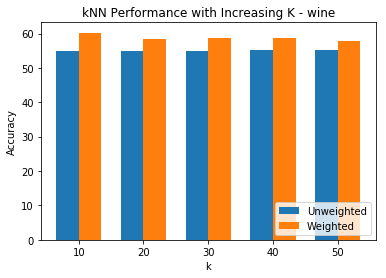

None


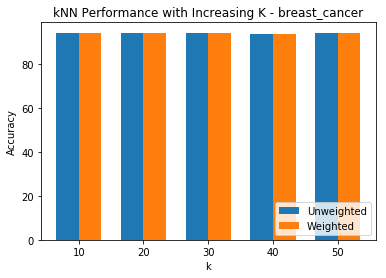

None


In [135]:
#Weighted 
is_weighted = [False, True]
#Set k test values
k_values = [10,20,30,40,50]
#Array to hold models
all_knns = []
all_knn_results = []
#Testing
for index,dataset in datasets.items():
    knns = []
    #Train and Test
    for weight in is_weighted:
        weight_knns = []
        for k in k_values:
            knn = kNN(dataset['train_x'].values,dataset['train_y'].values,k,weighted=weight)
            knn.test(dataset['test_x'].values,dataset['test_y'].values)
            weight_knns.append(knn)
        knns.append(weight_knns)
    #Get Results 
    knn_results = []
    knn_results_element = []
    for weight_knns in knns:
        knn_results_element = []
        for knn in weight_knns:
            knn_results_element.append(accuracy(knn.results))
        knn_results.append(knn_results_element)
    #Graph 
    N = len(k_values)
    ind = np.arange(N)
    performance1 = knn_results[0]
    performance2 = knn_results[1]
    plt.bar(ind, performance1,0.35, label='Unweighted')
    plt.bar(ind + 0.35,performance2,0.35,label='Weighted')
    plt.ylabel('Accuracy')
    plt.xlabel('k')
    plt.title('kNN Performance with Increasing K - ' + index)
    plt.xticks(ind + 0.35 / 2, k_values)
    plt.legend(loc='lower right')
    print(plt.show())
    all_knns.append(knns)
    all_knn_results.append(knn_results)

In [136]:
#Unweighted
#Wine
print(all_knn_results[0][0])
#Breast Cancer
print(all_knn_results[1][0])

[55.04287464271131, 54.87954267047775, 54.87954267047775, 55.28787260106166, 55.124540628828086]
[94.38596491228071, 94.38596491228071, 94.38596491228071, 93.6842105263158, 94.03508771929825]


Top array is unweighted, bottom is weighted. Weighted has a definite accuracy increase. But accuracy seems to dip as k increase, larger range of k might need to be tested but for now k=20 (or 30) is the most accuracy 

In [137]:
#Weighted
#Wine
print(all_knn_results[0][1])
#Breast Cancer
print(all_knn_results[1][1])

[60.22866476112699, 58.391180073499385, 58.71784401796651, 58.75867701102491, 57.94201714985709]
[94.38596491228071, 94.38596491228071, 94.38596491228071, 93.6842105263158, 94.03508771929825]


Top array is unweighted, bottom is weighted. Weighted has a definite accuracy much larger gap than for wine dataset. K doesn't have that much affect on the accuracy of weighted but seems to slightly decrease accuracy as k increases. K=10 (or 20,30) produces the most accurate model 